In [140]:
from transformers import (GPT2LMHeadModel, GPT2TokenizerFast,
                          BertForMaskedLM, BertTokenizerFast,
                          DistilBertForMaskedLM, DistilBertTokenizerFast,
                          RobertaForMaskedLM, RobertaTokenizerFast,
                          BlenderbotForCausalLM, BlenderbotTokenizer,
                          BigBirdForMaskedLM, BigBirdTokenizer,
                          ElectraForMaskedLM, ElectraTokenizerFast)
from multiprocessing import Pool
import pandas as pd
import glob
from itertools import product, combinations
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [141]:
from lmeval.datasets import NarrativesDataset, NeuroscoutDataset
from lmeval.engine import StridingForwardLM

In [81]:
### TO DOS:
# Rerun gpt for different window lengths, types and transcripts
# Visualize
# Look at correlations between punctuation and no punctuation
# Implement pliers extractor
# Run sample models

### Initialize list of models and parameters

In [105]:
transcripts = glob.glob('inputs/narratives/gentle/*/transcript*')
aligned = glob.glob('inputs/narratives/gentle/*/align.csv')
dataset_files = transcripts + aligned

In [106]:
model_classes = [GPT2LMHeadModel,
                 BertForMaskedLM,
                 DistilBertForMaskedLM, 
                 RobertaForMaskedLM, 
                 BlenderbotForCausalLM, 
                 BigBirdForMaskedLM,
                 ElectraForMaskedLM]
model_ids = ['gpt2', 
             'bert-base-uncased', 
             'distilbert-base-uncased',
             'roberta-base', 
             'facebook/blenderbot-400M-distill', 
             'google/bigbird-roberta-base', 
             'google/electra-base-discriminator']
tokenizer_classes = [GPT2TokenizerFast,
                     BertTokenizerFast,
                     DistilBertTokenizerFast,
                     RobertaTokenizerFast,
                     BlenderbotTokenizer,
                     BigBirdTokenizer,
                     ElectraTokenizerFast]
model_parameters = list(zip(model_classes, model_ids, tokenizer_classes))

In [5]:
ctx_lengths = [5, 10, 15, 20]

Create all combinations of files, model_parameters, and context lengths

In [6]:
parameters = list(product(dataset_files, 
                          model_parameters, 
                          ctx_lengths))
parameters = [(i[0], *i[1], i[2]) for i in parameters]

### Define validation function + utils
... also use to test validation script

In [7]:
def _make_dataset_id(datafile):
    ds_name_splits = datafile.split('/')
    narrative = ds_name_splits[3]
    ds_type = ds_name_splits[-1].split('.')[0]
    ds_id = '_'.join([narrative, ds_type])
    return ds_id

In [8]:
def _validate(datafile, model_class, model_id, tokenizer_class, ctx_length):
    tokenizer = tokenizer_class.from_pretrained(model_id)
    model = model_class.from_pretrained(model_id)
    dataset_name = _make_dataset_id(datafile)
    data = NarrativesDataset(datafile, dataset_name)
    data.text = data.text[:100]
    if any([b in model_id for b in ['bert','electra',
                                    'bigbird']]):
        engine = StridingMLM(context_length=ctx_length)
    else:
        engine = StridingForwardLM(context_length=ctx_length)
    result = engine.run(data, tokenizer, model, model_id)
    return result

In [ ]:
for p in parameters:
    _validate(*p)

In [ ]:
pool = Pool(2)

In [61]:
results = pool.starmap(_validate, parameters)
pool.close()

## Read in data and plot

In [162]:
logs = glob.glob('outputs/narratives/*')

In [163]:
for i, l in enumerate(logs):
    ldf = pd.read_csv(l, sep='\t', index_col=0)
    if i % 100 == 0:
        print(f'{i} of {len(logs)}')
    if l == logs[0]:
        all_logs = ldf
    else:
        all_logs = pd.concat([all_logs, 
                              ldf], ignore_index=True)
all_logs['is_true'] = (all_logs['target'] == all_logs['top_predicted']).astype(int)
all_logs['surprisal'] = -np.log2(all_logs['prob_true'])
all_logs = all_logs.replace({'aligned': 'nopunct', 'transcript':'punct'})
metrics = ['loss', 'is_true', 'surprisal', 'entropy', 'prob_true', 'prob_predicted']
aggs = all_logs.groupby(['type', 'model', 'context_size', 'dataset'])[metrics].mean().reset_index()
fig, ax = plt.subplots(ncols=6, figsize=(18,3))
for i, m in enumerate(metrics):
    sns.pointplot(data=aggs, 
                  x='context_size', 
                  y=m, 
                  hue='type', 
                  ax=ax[i])
    #if i != 4:
    #    ax[i].legend('')
    #else:
    #    ax[i].legend(title='')
    ax[i].set_title(m)
    ax[i].set_ylabel('')
    #ax[i].set_xticklabels(labels=np.arange(0,35,5), rotation=90)
plt.tight_layout()
plt.show()

0 of 347
100 of 347
200 of 347
300 of 347


0 of 14


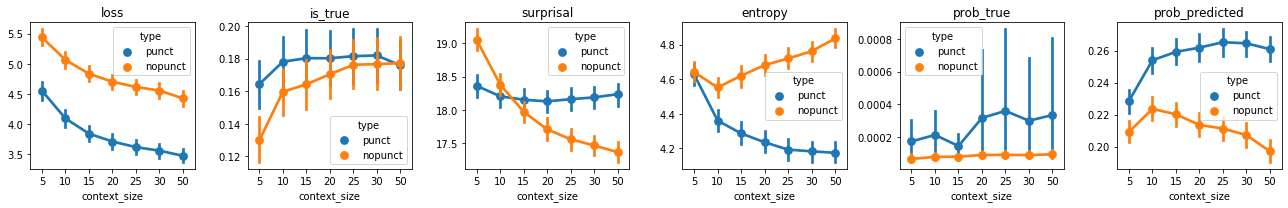

In [183]:
logs = glob.glob('outputs/sherlock/*')
for i, l in enumerate(logs):
    ldf = pd.read_csv(l, sep='\t', index_col=0)
    if i % 100 == 0:
        print(f'{i} of {len(logs)}')
    if l == logs[0]:
        all_logs = ldf
    else:
        all_logs = pd.concat([all_logs, 
                              ldf], ignore_index=True)
all_logs['is_true'] = (all_logs['target'] == all_logs['top_predicted']).astype(int)
all_logs['surprisal'] = -np.log2(all_logs['prob_true'])
all_logs = all_logs.replace({'aligned': 'nopunct', 'transcript':'punct'})
metrics = ['loss', 'is_true', 'surprisal', 'entropy', 'prob_true', 'prob_predicted']
fig, ax = plt.subplots(ncols=6, figsize=(18,3))
for i, m in enumerate(metrics):
    sns.pointplot(data=all_logs, 
                  x='context_size', 
                  y=m, 
                  hue='type', 
                  ax=ax[i])
    #if i != 4:
    #    ax[i].legend('')
    #else:
    #    ax[i].legend(title='')
    ax[i].set_title(m)
    ax[i].set_ylabel('')
    #ax[i].set_xticklabels(labels=np.arange(0,35,5), rotation=90)
plt.tight_layout()
plt.show()